# M07 - Caracterización y Agrupación de Usuarios en Redes Sociales mediante Análisis de Mensajes

Grupo 1:

>- Juan Pablo Baudoin
>- Fran Cassinese
>- Martin Gruber
>- Mariana Abayay


# Análisis exploratorio

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import os
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode
from pycountry import languages
from langid.langid import LanguageIdentifier, model

from lib.utils import *

from pandarallel import pandarallel

pandarallel.initialize()
sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [14]:
# Estos paquetes son necesarios para el código (y no vienen instalados por defecto en Anaconda),
# descomentar los módulos que falten para instalarlos:

#!pip install emoji --quiet
#!pip install pycountry --quiet
#!pip install langdetect --quiet
#!pip install pandarallel --quiet
#!pip install langid  --quiet

# pip install OpenNMT-py --quiet
# !pip install transformers torch  --quiet

## 1. Lectura de datos

In [15]:
base_name = "dataset_diplodatos_corregido"
src_ds = f"data/{base_name}.csv"
# if file does not exist, download it
if not os.path.exists(src_ds):
    web_src = "https://github.com/jpbaudoin/message_analisis/raw/main/data/dataset_diplodatos_corregido.csv"
    df_ori = pd.read_csv(web_src)
    # write to file
    df_ori.to_csv(src_ds, index=False)
else:
    df_ori = pd.read_csv(src_ds)


In [16]:
# Vamos a trabajar con una copia de los datos y generamos un archivo nuevo en el que adicionaremos 
# las columnas con información adicional.
work_file = f"data/{base_name}_enhanced.csv"
if not os.path.exists(work_file):
    print(f"Creating {work_file}")
    df_ori.to_csv(work_file, index=False)
    df = df_ori.copy()
else:
    print(f"File {work_file} already exists. Loading it.")
    df = pd.read_csv(work_file)

df.info()


File data/dataset_diplodatos_corregido_enhanced.csv already exists. Loading it.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150519 entries, 0 to 150518
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       150519 non-null  int64  
 1   commodity                119324 non-null  object 
 2   source_posted_at         150519 non-null  object 
 3   trade_type               141323 non-null  object 
 4   chat_id                  150262 non-null  float64
 5   telegram_user_id         150262 non-null  float64
 6   message_text             150519 non-null  object 
 7   date_source_posted_at    150519 non-null  object 
 8   message_text_clean       150519 non-null  object 
 9   message_encoding         150519 non-null  object 
 10  message_text_clean_utf8  150519 non-null  object 
 11  message_length           150519 non-null  int64  
 12  message_words            150519 no

## 2. Análisis de datos categóricos y texto
En una primera revisión vamos a ver:
- Valores nulos
- Frecuencias de variables categóricas: commodity, trade_type, chat_id, telegram_user_id
- Análisis del campo message_text: mediante una inspección de datos muestral se ve que existen varios idiomas, que se tienen múltiples encodings y se detecta el uso de emojis. Comportamiento esperado en mensajes de canales de chat en aplicaciones como telegram o whatsapp. Para el análisis del campo message_text, generaremos información adicional sobre el mismo:
  * Idioma
  * longitud caracteres
  * Numero de palabras
  * Cantidad de saltos de linea
  * Encodings



### 2.1 Nulos

In [17]:
missing_values = df_ori.isnull().mean() * 100
missing_values = missing_values.sort_values(ascending=False)

filter_columns = missing_values > 0

print("############")
print("Columnas con valos nulos")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}: {percentage:.2f}%")


filter_columns = missing_values == 0
print("############")
print("Columnas sin valos nulos")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}")

############
Columnas con valos nulos
    commodity: 20.72%
    trade_type: 6.11%
    chat_id: 0.17%
    telegram_user_id: 0.17%
############
Columnas sin valos nulos
    id
    source_posted_at
    message_text


Es esperado que las columnas comodity, trade_type tengan valores nulos, pero en el caso de chat_id y telegram_user_id es un problema dado que nos interesa correlacionar usuarios y canales, por lo que esos registros deberían ser eliminados en la etapa de limpieza.

Las columnas completas son el id, la fecha y el mensaje, lo que está ok. En el caso de la fecha, está en formato de texto, por lo que hay que convertirla de tipo `date`.

### 2.2. Frecuencias simples

#### 2.2.1. Top 10 de conteos

In [18]:
### Frecuencia de variables categóricas
print_top(df, 'commodity', "Currency", top=11)
print("--------")

print_top(df, 'chat_id', "Canal", top=11)
print("--------")

print_top(df, 'telegram_user_id', "Users", top=11)
print("--------")

print_top(df, 'trade_type', "Tipo Operación", top=11)
print("--------")


Top 11 Currency (commodity):
01 - N/A: 31195 	 (20.72%  - 20.72%) 	 (NaN)
02 - BTC: 5866 	 (3.9%  - 24.62%) 	 (W/NaN 4.92% - 4.92%)
03 - ETH: 3920 	 (2.6%  - 27.22%) 	 (W/NaN 3.29% - 8.21%)
04 - LTC: 2290 	 (1.52%  - 28.74%) 	 (W/NaN 1.92% - 10.13%)
05 - DYDX: 1832 	 (1.22%  - 29.96%) 	 (W/NaN 1.54% - 11.67%)
06 - BNB: 1636 	 (1.09%  - 31.05%) 	 (W/NaN 1.37% - 13.04%)
07 - AXS: 1565 	 (1.04%  - 32.09%) 	 (W/NaN 1.31% - 14.35%)
08 - TRX: 1531 	 (1.02%  - 33.11%) 	 (W/NaN 1.28% - 15.63%)
09 - MATIC: 1481 	 (0.98%  - 34.09%) 	 (W/NaN 1.24% - 16.87%)
10 - GALA: 1446 	 (0.96%  - 35.05%) 	 (W/NaN 1.21% - 18.08%)
11 - DOGE: 1361 	 (0.9%  - 35.95%) 	 (W/NaN 1.14% - 19.22%)
--------
Top 11 Canal (chat_id):
01 - 79.0: 29916 	 (19.88%  - 19.88%) 	 (W/NaN 19.91% - 19.91%)
02 - 101.0: 11278 	 (7.49%  - 27.37%) 	 (W/NaN 7.51% - 27.42%)
03 - 169.0: 9553 	 (6.35%  - 33.72%) 	 (W/NaN 6.36% - 33.78%)
04 - 173.0: 4433 	 (2.95%  - 36.67%) 	 (W/NaN 2.95% - 36.73%)
05 - 180.0: 3988 	 (2.65%  - 39.32%) 	 (W/

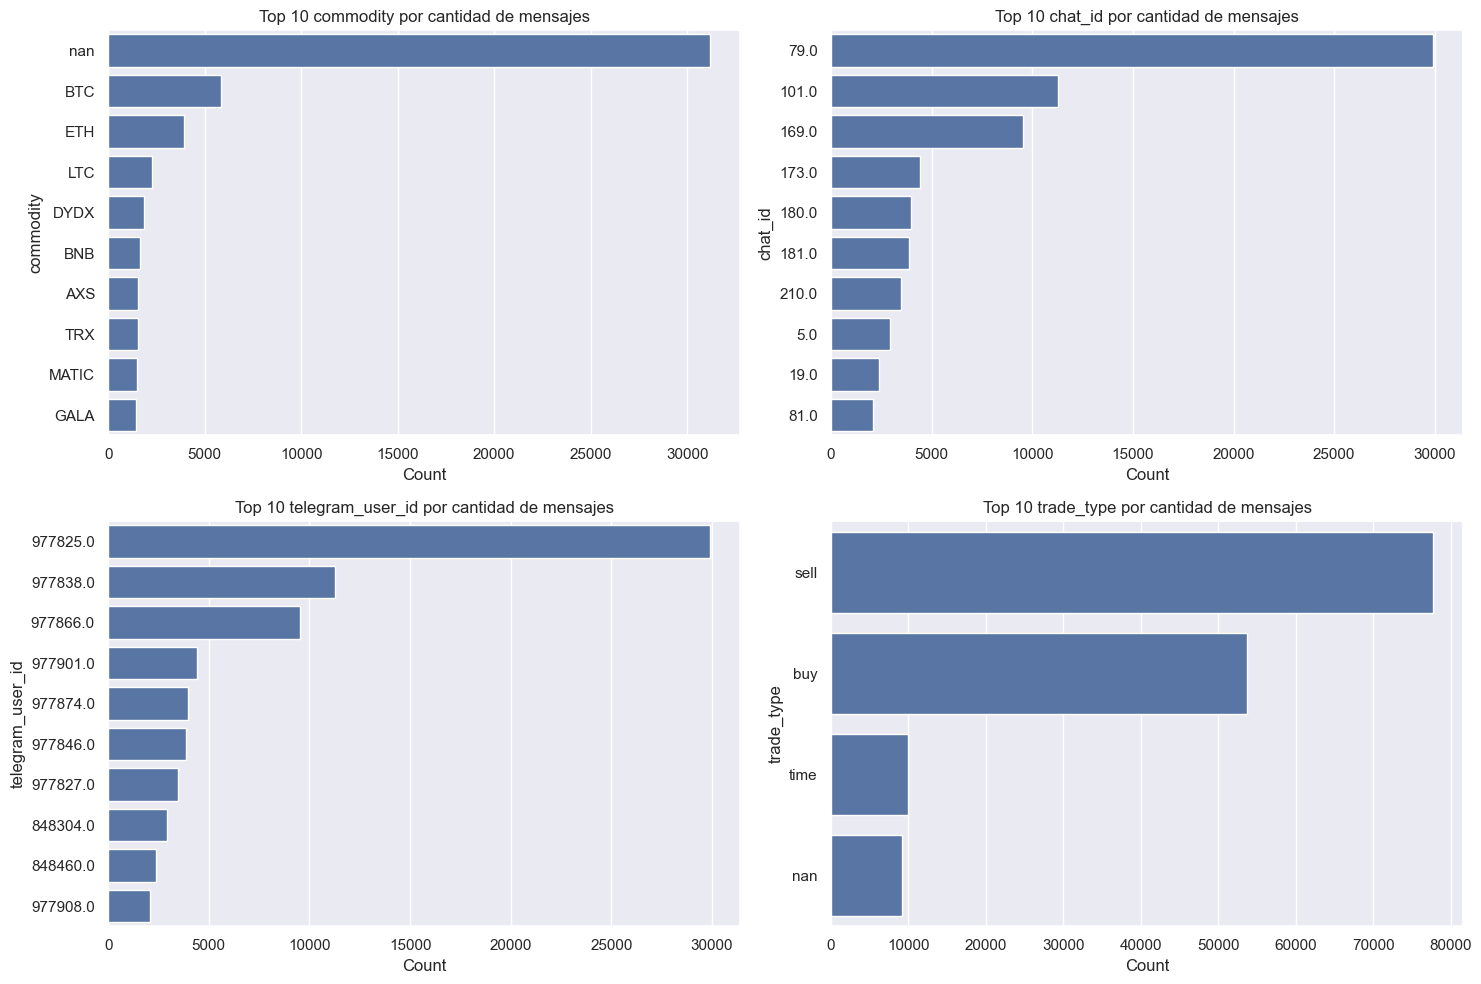

In [19]:
columns_to_plot = ['commodity', 'chat_id', 'telegram_user_id', 'trade_type']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    value_counts = df[column].astype(str).value_counts(dropna=False).head(10)
    
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 {column} por cantidad de mensajes')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

En la frecuencias simples de los datos categóricos tenemos:
- Commodity: como es esperado, las cryptomonedas más populares son las que tienen mayor participación, es importante notar que casi el 21% de los registros tienen valores nulos, por lo que la asociación monedas a mensajes tienen una gran cobertura. Por otro lado, el top 10 de las monedas cubre casi un 20% de los datos.
- Chat_id: se puede apreciar que hay un canal con muchos más mensajes que el resto 19.88%, los dos que siguen 7.49% y 6.35% y despues menos de 3% y 2%. El top 10 de canales cubre el 49% de los datos.
- telegram_user_id: Es interesa notar que el top 10 de los usuarios tiene exactamente las mismas cantidades de mensajes que los chats, esto significa que en esos canales solo escribe un usuario.

#### 2.2.2. Cruce de variables `telegram_user_id` y `chat_id`

In [20]:
chat_ids = df['chat_id'].nunique()
print(f"Number of chat_ids: {chat_ids}")

users = df['telegram_user_id'].nunique()
print(f"Number of users: {users}")

print(f"El {10/chat_ids:.2%}(top 10) de los canales concentra el 49.13% de los mensajes")
print(f"El {10/users:.2%}(top 10) de los usuarios concentra el 49.13% de los mensajes")


Number of chat_ids: 491
Number of users: 3892
El 2.04%(top 10) de los canales concentra el 49.13% de los mensajes
El 0.26%(top 10) de los usuarios concentra el 49.13% de los mensajes


Es interesante evaluar la presencia de canales que llamaremos de *difusión* (donde escribe únicamente un usuario) y canales de *conversación* (donde pueden escribir varios integrantes). También habría que definir si canales con 2 o 3 usuarios deberían ser considerados como una u otra categoría.

In [21]:
# Canales con un solo usuario
chat_users = df.groupby('chat_id')['telegram_user_id'].nunique()
chat_users = chat_users.sort_values(ascending=False)
single_user_chats = chat_users[chat_users == 1]
print(f"Number of chats with a single user: {single_user_chats.count()}")
print(f"Number of chats with a single user: {single_user_chats.count()/chat_ids:.2%}")


# Usuarios con un solo canal
user_chats = df.groupby('telegram_user_id')['chat_id'].nunique()
user_chats = user_chats.sort_values(ascending=False)
single_chat_users = user_chats[user_chats == 1]
print(f"Number of users with a single chat: {single_chat_users.count()}")
print(f"Number of users with a single chat: {single_chat_users.count()/users:.2%}")

Number of chats with a single user: 405
Number of chats with a single user: 82.48%
Number of users with a single chat: 3857
Number of users with a single chat: 99.10%


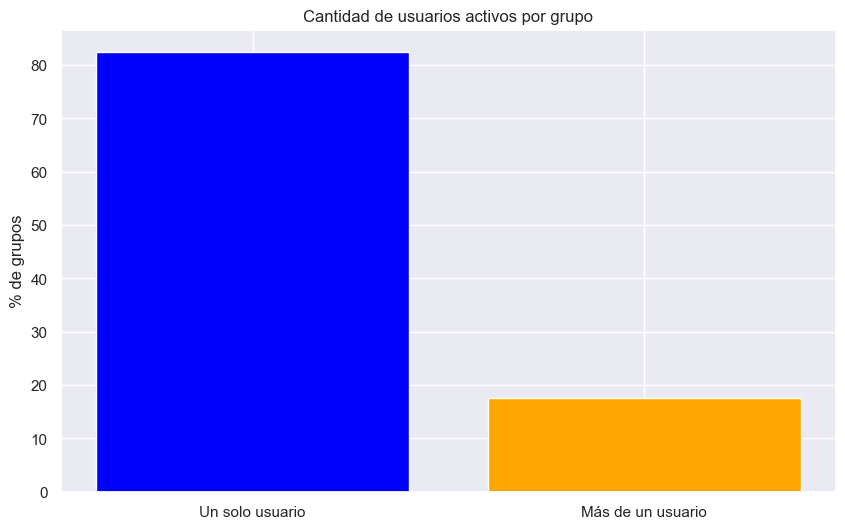

In [22]:
distinct_people_per_group = df.groupby('chat_id')['telegram_user_id'].nunique().reset_index()
distinct_people_per_group.columns = ['chat_id', 'distinct_people_count']
messages_per_group = df.groupby('chat_id').size().reset_index()
messages_per_group.columns = ['chat_id', 'message_count']

merged_df = pd.merge(distinct_people_per_group, messages_per_group, on='chat_id')
merged_df
merged_df = merged_df.sort_values(by='distinct_people_count', ascending=False)

merged_df 

count_equal_1 = (merged_df['distinct_people_count'] == 1).sum()
count_greater_1 = (merged_df['distinct_people_count'] > 1).sum()

total_count = count_equal_1 + count_greater_1

# Normalizar el conteo
normalized_counts = [count_equal_1 / total_count * 100, count_greater_1 / total_count * 100]

# Crear bar plot
labels = ['Un solo usuario', 'Más de un usuario']

plt.bar(labels, normalized_counts, color=['blue', 'orange'])
plt.ylabel('% de grupos')
plt.title('Cantidad de usuarios activos por grupo')
plt.show()

Por lo que se ve, en la mayoría de los canales escribe un solo usuario, menos del 20% de los canales tiene más de un usuario.

En cuanto a los usuarios, solo un 0.8% escribe en más de un canal.

In [23]:
# Canales con más de un usuario sort by number of users
multi_user_chats = chat_users[chat_users > 1]

print(f"Number of chats with more than one user: {multi_user_chats.count()}")
print(f"Number of chats with more than one user: {multi_user_chats.count()/chat_ids:.2%}")
print(multi_user_chats)

print("--------")

# Usuarios con más de un canal
multi_chat_users = user_chats[user_chats > 1]
print(f"Number of users with more than one chat: {multi_chat_users.count()}")
print(f"Number of users with more than one chat: {multi_chat_users.count()/users:.2%}")
print(multi_chat_users)




Number of chats with more than one user: 86
Number of chats with more than one user: 17.52%
chat_id
3455.0    519
3389.0    510
3396.0    372
1.0       275
2964.0    214
         ... 
3464.0      2
3454.0      2
78.0        2
3457.0      2
3636.0      2
Name: telegram_user_id, Length: 86, dtype: int64
--------
Number of users with more than one chat: 35
Number of users with more than one chat: 0.90%
telegram_user_id
5380.0       4
2640755.0    2
2680874.0    2
2696977.0    2
2686427.0    2
            ..
2626020.0    2
610825.0     2
2634301.0    2
2989908.0    2
2978476.0    2
Name: chat_id, Length: 35, dtype: int64


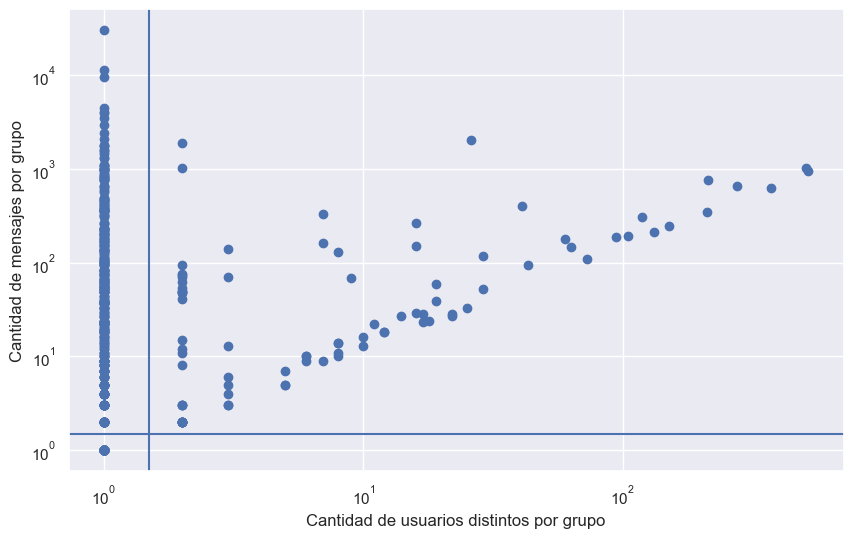

In [24]:
fig, ax = plt.subplots()
ax.scatter(merged_df['distinct_people_count'], merged_df['message_count'])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Cantidad de usuarios distintos por grupo')
ax.set_ylabel('Cantidad de mensajes por grupo')
ax.axvline(1.5)
ax.axhline(1.5)
x = np.linspace(np.min(merged_df['distinct_people_count']), np.max(merged_df['distinct_people_count']))
y = np.linspace(np.min(merged_df['message_count']), np.max(merged_df['message_count']))

Este análisis indica que si bien es posible la publicación cruzada en canales, no es algo tan común usando el mismo usuario. En su mayoría los usuarios que publican en más de un canal solo lo hacen en dos y tenemos un sólo caso que lo hace en 4. 

En cuanto a canales que tienen más de un usario no son muchos: 86 en total y coresponde a 17.52% del total de chats.


### 2.3. Análisis del campo message_text
#### 2.3.1. Limpieza de datos y enriquecimiento simple

Para continuar con el análisis exploratorio, como indicamos antes, necesitamos realizar una limpieza y enriequecimiento de datos inicial. Vamos a proceder a adicionar las siguientes columnas:
- date_source_posted_at: transformación del campo date_source a formato fecha
- message_text_clean: aplicar las siguentes transformaciones al message_text
    - Clean_lbr: consolidar saltos de linea repetidos en uno solo
    - Clean emojis: Remover los emojis
- message_encoding: identificar el encoding de message_text_clean
- message_text_clean_utf8: convertir message_text_clean a encoding utf8, cuando no sea utf8 o ascii.
- message_length: Contar los caracteres de linea de message_text_clean_utf8
- message_words: Contar las palabras en el campo message_text_clean_utf8
- message_lbr: Contar los salos de linea de message_text_clean_utf8
- message_encoding2: identificar el encoding de message_text_clean_utf8
- language: identificar el idioma de message_text_clean_utf8

La razón por la cual eliminamos los emojis y llevamos los mensajes a un mismo encoding es para poder utilizar los paquetes de identificación de idiomas, que presentaban problemas sobre los datos originales.

In [25]:
force_process = True

if 'message_length' not in df.columns or force_process :

    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # sort the data by chat_id and date_source_posted_at
    df = df.sort_values(by=['chat_id', 'date_source_posted_at'])

    ### Limpieza sobre el encoding original de los mensajes ###
    ###########################################################
    # Removemos multiples saltos de linea
    df['message_text_clean'] = df['message_text'].parallel_apply(clean_lbr)

    # Eliminar emojis y añadir columna
    df['message_text_clean'] = df['message_text_clean'].parallel_apply(remove_emojis).str.strip().str.lower()

    # Detectamos el enoding del campo
    df['message_encoding'] = df['message_text_clean'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])


    ### Queremos manejar un solo encoding o encoding más estandars ###
    #################################################################
    df['message_text_clean_utf8'] = df['message_text_clean']

    # Generamos una lista de caracteres(data/map_list.csv) que daban problemas de traduccion a utf-8
    # Buscamos caracteres para reemplazarlos en utf-8, en caso de no encontrar, les pusimos una marca o 
    # los encodeamos en ascii con unidecode.

    
    confusable_file = "data/map_list.csv"
    char_map_list = pd.read_csv(confusable_file, sep=',', 
                                    comment='#', 
                                    header=None, names=['src', 'enc', 'dst', 'operation'],
                                    quoting=csv.QUOTE_NONE)


    enc_list = char_map_list['enc'].unique()
    char_map_list_enc = {}
    for enc in enc_list:
        print(f"Encoding: {enc}")
        # filter the data frame for enc
        flt = char_map_list['enc'] == enc
        char_map_list_cur = char_map_list[flt].set_index('src')[['dst','operation']].to_dict('index')
        char_map_list_enc[enc] = char_map_list_cur


    # funciones: 
    # translate_chars(text, encoding, ext_chars_map=None, unidecode_miss=False)
    # encode_utf8(text, encoding, gen_missed_chars=False, ext_chars_map=None)
    flt = (df['message_encoding'] != 'utf-8') & (df['message_encoding'] != 'ascii')
    df.loc[flt, 'message_text_clean_utf8'] = df[flt].apply( 
        lambda row:
            encode_utf8(row['message_text_clean'], 
                        row['message_encoding'],
                        False , char_map_list_enc), axis=1)


    


    # flt = df['message_encoding'] != 'utf-8'
    # df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    df['message_encoding2'] = df['message_text_clean_utf8'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])

    # Añadir columna con la longitud del mensaje sin emojis
    df['message_length'] = df['message_text_clean_utf8'].str.len()

    # Añadir columna con el número de palabras
    df['message_words'] = df['message_text_clean_utf8'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    df['message_lbr'] = df['message_text_clean_utf8'].parallel_apply(count_line_breaks)
    df.to_csv(work_file, index=False)


Encoding: cp1252
Encoding: cp1254
Encoding: EUC-JP
Encoding: MacRoman
Encoding: GB2312
Encoding: Johab
Encoding: TIS-620
--------------------
o
ố
--------------------
--------------------
à
à
--------------------
--------------------
á
á
--------------------
--------------------
á
á
--------------------
--------------------
á
á
--------------------
--------------------
ù
ù
--------------------
--------------------
'
’
--------------------
--------------------
à
à
--------------------
--------------------
á
á
--------------------
--------------------
'
’
--------------------
--------------------
â
ậ
--------------------
--------------------
ô
ô
--------------------
--------------------
'
’
--------------------
--------------------
o
ơ
--------------------
--------------------
á
á
--------------------
--------------------
nan
ồ
--------------------
--------------------
a
ạ
--------------------
--------------------
i
ỉ
--------------------
--------------------
ú
ú
--------------------
---

In [26]:
df['message_encoding2'] = df['message_text_clean_utf8'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])


In [27]:
def translate_chars(text, encoding, ext_chars_map=None, unidecode_on_miss=False):
    changed = False
    new_text_chars = []
    enc = chardet.detect(text.encode())['encoding']
    
    encoding_map = {
        "Windows-1254": "cp1254",
        "ISO-8859-9": "cp1254",
        "Windows-1252": "cp1252",
        "ISO-8859-1": "cp1252",
    }
    encoding = encoding_map.get(encoding, encoding)

    miss_text = text
    if unidecode_on_miss:
        miss_text = unidecode(text)
        # encode the text to utf-8
        miss_text = miss_text.encode().decode('utf-8')
        

    # Probably remove this and use the original encoding
    if encoding not in ext_chars_map:
        return miss_text
    
    char_map = ext_chars_map[encoding]

    
    if text in char_map:
        changed = True
        operation = char_map[text]['operation']

        if  operation == 'convert':
            new_text = char_map[text]['dst']
        elif operation == 'unicode':
            new_text = unidecode(text)
        else:
            # convert to utf-8 code
            utf_code = char_map[text]['dst']
            # char_code = "\xe2\x82\xac"
            # print(utf_code, type(utf_code))
            # print(char_code, type(char_code))

            # utf_code2 =to_raw_string(utf_code)
            # print(utf_code2)
            # char_bytes = bytes(utf_code2, 'latin1')
            char_bytes = utf_code.encode('latin1')

            print(char_bytes)
            new_text = char_bytes.decode('utf-8')
    else:
        return miss_text

    if changed:
        print("--------------------")
        print(new_text)
        print(text)
        print("--------------------")
    return new_text

def encode_utf8(text, encoding, gen_missed_chars=False, ext_chars_map=None):

    if pd.isna(text):
        return text

    
    try:
        text_encoded = text.encode(encoding)
    except UnicodeError as e:
        # split the text in two parts
        text1 = text[:e.start]
        text2 = text[e.end:]
        # encode the two parts
        text1_utf = encode_utf8(text1, encoding, gen_missed_chars, ext_chars_map)
        text2_utf = encode_utf8(text2, encoding, gen_missed_chars, ext_chars_map)
        # process missed characters
        missed_chars = text[e.start:e.end]
        missed_chars_utf = translate_chars(missed_chars, encoding, ext_chars_map, unidecode_on_miss=True)

        text1_utf_enc = chardet.detect(text1_utf.encode())['encoding']
        missed_chars_utf_enc = chardet.detect(missed_chars_utf.encode())['encoding']
        text2_utf_enc = chardet.detect(text2_utf.encode())['encoding']
        print("ENCODINGS: ",text1_utf_enc, missed_chars_utf_enc, text2_utf_enc)

        rst = f"{text1_utf}{missed_chars_utf}{text2_utf}"
        rst_enc = chardet.detect(rst.encode())['encoding']
        print("ENCODINGS RST: ",rst_enc)


        # appenf text to file
        if gen_missed_chars:
            with open("1_error_messages_encode.txt", "a") as f:
                f.write(f"{text[e.start:e.end]},{encoding}\n")

        return rst


    try:
        text_decoded = text_encoded.decode('utf-8')
    except UnicodeError as e:

        text1 = text[:e.start]
        text2 = text[e.end:]
        # encode the two parts
        text1_utf = encode_utf8(text1, encoding, gen_missed_chars, ext_chars_map)
        text2_utf = encode_utf8(text2, encoding, gen_missed_chars, ext_chars_map)
        # process missed characters
        missed_chars = text[e.start:e.end]
        missed_chars_utf = translate_chars(missed_chars, encoding, ext_chars_map, unidecode_on_miss=True)

        text1_utf_enc = chardet.detect(text1_utf.encode())['encoding']
        missed_chars_utf_enc = chardet.detect(missed_chars_utf.encode())['encoding']
        text2_utf_enc = chardet.detect(text2_utf.encode())['encoding']
        print("ENCODINGS: ", text1_utf_enc, missed_chars_utf_enc, text2_utf_enc)
        rst = f"{text1_utf}{missed_chars_utf}{text2_utf}"
        rst_enc = chardet.detect(rst.encode())['encoding']
        print("ENCODINGS RST: ",rst_enc)

        # appenf text to file
        if gen_missed_chars:
            with open("2_error_messages_decode", "a") as f:
                f.write(f"{text[e.start:e.end]},{encoding}\n")
        return rst

    text_enc = chardet.detect(text_decoded.encode())['encoding']
    print("ENCODINGS: ", text_enc)

    return text_decoded

def simple_utf_encode(text, encoding):
    try:
        text_encoded = text.encode(encoding)
    except UnicodeError as e:
        return None

    try:
        text_decoded = text_encoded.decode('utf-8')
    except UnicodeError as e:
        return None

    return text_decoded


In [29]:
url = "https://www.unicode.org/Public/security/15.0.0/confusables.txt"
confusables_df = pd.read_csv(url, sep=';', comment='#', header=None, names=['src', 'dst', 'extra'])
confusables_df['src'] = confusables_df['src'].str.strip()
confusables_df['dst'] = confusables_df['dst'].str.strip()

confusables_df = confusables_df[~confusables_df['dst'].str.contains(' ')]
confusables_df["src_char"] = confusables_df["src"].apply(lambda x: chr(int(x, 16)))
confusables_df["dst_char"] = confusables_df["dst"].apply(lambda x: chr(int((x.replace('\t', '')), 16)))

confusables_df['src_enc'] = confusables_df["src"].apply(lambda x: chardet.detect(x.encode())['encoding'])

# exluding the characters that are in utf-8 encoding and ascii encoding
confusables_df = confusables_df[~confusables_df['src_enc'].isin(['utf-8', 'ascii'])]

# export the confusables_df to a python dictionary
confusables_dict = confusables_df.set_index('src_char')['dst_char'].to_dict()

def replace_confusables(text):
    return ''.join(confusables_dict.get(char, char) for char in text)

In [30]:
# df['message_text_clean_utf8_2'] = df['message_text_clean_utf8'].apply(replace_confusables)

In [32]:
ids = [
27491,
27492,
60965,
60963,
60964,
60966,
80745,
80746,
80749,
91247,
99399,
99401,
99407,
99388,
103383,
103382,
103380,
103379,
1907,
1908,
1917,
1918,
1920,
1922,
12716,
12722,
12723,
12724,
57406,
57408,
57409,
57411]

# select messages with index in the list of ids
df_ids = df.iloc[ids]
df_ids.info()
df_ids[['id', 'chat_id', 'telegram_user_id', 'trade_type', 'commodity']]

df_ids.to_csv("data/messages_sample_tokenization.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 27491 to 57411
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   id                         32 non-null     int64              
 1   commodity                  25 non-null     object             
 2   source_posted_at           32 non-null     object             
 3   trade_type                 32 non-null     object             
 4   chat_id                    32 non-null     float64            
 5   telegram_user_id           32 non-null     float64            
 6   message_text               32 non-null     object             
 7   date_source_posted_at      32 non-null     datetime64[ns, UTC]
 8   message_text_clean         32 non-null     object             
 9   message_encoding           32 non-null     object             
 10  message_text_clean_utf8    32 non-null     object             
 11  messag

In [ ]:
# sentences = ["I'm happy", "I'm full of happiness", "I'm not happy"]
# # given the list of sentences, we want how simmilar they are to each other
# # we can use the cosine similarity to find the similarity between the sentences using bert
# # Automaticaly compare one sentence to another
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # encode the sentences
# embeddings = model.encode(sentences)




In [36]:
# identificacion de idioma con librería langdetect
force_lang_detect = True
if 'language' not in df.columns or force_lang_detect:
    df['language'] = df['message_text_clean_utf8'].parallel_apply(detect_language)
    df.to_csv(src_ds, index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

No features in text. https://www.theblock.co/post/162913/ethereums-final-proof-of-stake-test-merge-is-live-on-goerli?utm_source=twitter&utm_medium=social
No features in text. https://thehiddenwiki.com/new-long-v3-onion-services-version-3-hidden-service-links-on-the-hidden-wiki/
No features in text. https://www.tradingview.com/chart/btcusdt/wq95qni6-buylong-1h-4h-green-area-signal-buy-bo-mid-band/wq95qni6
No features in text. https://www.tradingview.com/chart/btcusdt/accixc3k-buylong-4h-green-area-oversold-rebound/accixc3k
No features in text. https://www.tradingview.com/chart/btcusdt/beaflobw-buylong1h-green-area-signal-buy-bo-mid-band/beaflobw
No features in text. https://www.tradingview.com/chart/ethusdt/7ppqlkph-buylong-1h-green-area-signal-buy-bo-mid-band/7ppqlkph
No features in text. https://www.tradingview.com/chart/ethusdt/7f3mdpx6-buy-eth-ethusdt-buylong-timeframe-4h-sadis/7f3mdpx6
No features in text. https://www.tradingview.com/chart/btcusdt/iwnufnrm-buy-btc-btcusdt-buylong-t

In [38]:
# Identificación de idioma con librería langid
from langid.langid import LanguageIdentifier, model

identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
def detect_language2(text):
    try:
        return list(identifier.classify(text))
    except Exception as e:
        print(e, text)
        return "Error langdetect"


In [39]:
force_lang_detect2 = False
if 'language2' not in df.columns or force_lang_detect2:
    df['lang_tmp'] = df['message_text_clean_utf8'].parallel_apply(detect_language2)
    df[['language2', 'language2_score']] = pd.DataFrame(df['lang_tmp'].tolist(), index=df.index)
    df.drop(columns=['lang_tmp'], inplace=True)
    df.to_csv(src_ds, index=False)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [40]:
# language3 is equal to language2 if the score is greater than 0.5
df['language3'] = df['language2']
df.loc[df['language2_score'] < 0.5, 'language3'] = '??'


#### 2.3.2. Revisión de nuevos datos

##### a. Encoding

In [41]:
# count the number of messages per encoding
print(df['message_encoding'].value_counts())
print("--------")
print(df['message_encoding2'].value_counts())

message_encoding
ascii           131331
utf-8             8273
Windows-1254      5666
Windows-1252      3745
ISO-8859-1        1125
                 ...  
Johab                5
EUC-JP               4
windows-1253         1
TIS-620              1
GB2312               1
Name: count, Length: 12, dtype: int64
--------
message_encoding2
ascii           142152
utf-8             8273
Windows-1252        49
MacRoman            17
ISO-8859-1          17
ISO-8859-9          11
Name: count, dtype: int64


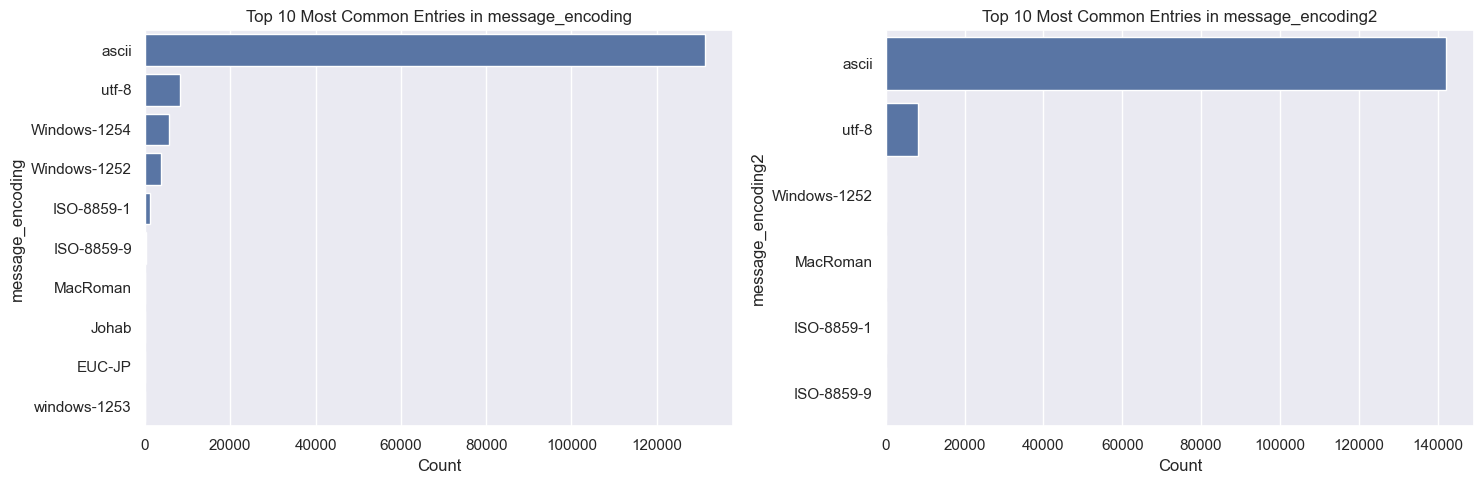

In [42]:
columns_to_plot = ['message_encoding', 'message_encoding2']
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over the columns and corresponding axes
for i, column in enumerate(columns_to_plot):
    # Count the occurrences of each value in the column, including NaNs
    value_counts = df[column].value_counts(dropna=False).head(10)
    
    # Convert value_counts to a DataFrame
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    # Create the horizontal barplot
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 Most Common Entries in {column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

In [44]:
# from df filter rows where message_encoding is not utf-8 
# and message_text_clean is not equal to message message_text_clean_utf8
filter_rows = (df['message_encoding'] != 'utf-8') & (df['message_text_clean'] != df['message_text_clean_utf8'])
print(f"Number of rows with message_encoding different from utf-8 and")
print(f"message_text_clean different from message_text_clean_utf8: {filter_rows.sum()}")
print("--------")


for index, row in df[filter_rows][['message_text_clean', 'message_text_clean_utf8', 'message_encoding', 'message_encoding2']].head(3).iterrows():
    print(row['message_encoding'])
    print(row['message_text_clean'])
    print("   -> ")
    print(row['message_encoding2'])
    print(row['message_text_clean_utf8'])
    print("--------")



Number of rows with message_encoding different from utf-8 and
message_text_clean different from message_text_clean_utf8: 10835
--------
Windows-1252
target 40$. chốt all
   -> 
ascii
target 40$. chot all
--------
Windows-1252
if you manage to explain why it is scam with any proof of facts, i’ll give you 1eth
   -> 
ascii
if you manage to explain why it is scam with any proof of facts, i'll give you 1eth
--------
Windows-1252
dyor - promo for yooshi 2k22
done few calls for this dev..so far so good..token is up for 26 hours so far..holding well..at 40.7k mc..personally going to check out these guys and the upcoming stuff !!!
____________________________________
 missed yooshi? don’t miss yooshi 2k22. the coin that will create huge abuzz this year and beyond!
 launched few hours ago
fairlaunch
rennounced
low cap high potential
no dev wallet
+ big influencers on board 
ape now, potential token!
telegram:
https://t.me/yooshi2k22
website: http://yooshi2k22.site
contract address:
0xe8a46f794b

Ahora se tienen datos con ascii y utf8.
Los cambios de encoding afectan a palabras con acentos de distintos tipos, comillas simples, carateres no imprimibles y caracteres de monedas.
Como puede afectar el cambio de encoding a la detección de idiomas?
Conviene realizar la detección previo a el cambio de encoding?
Se puede hacer reemplazo de caracteres confundibles en otro encoding a utf-8? 
Los paso a utf8 o a ascii?

##### b. Idioma

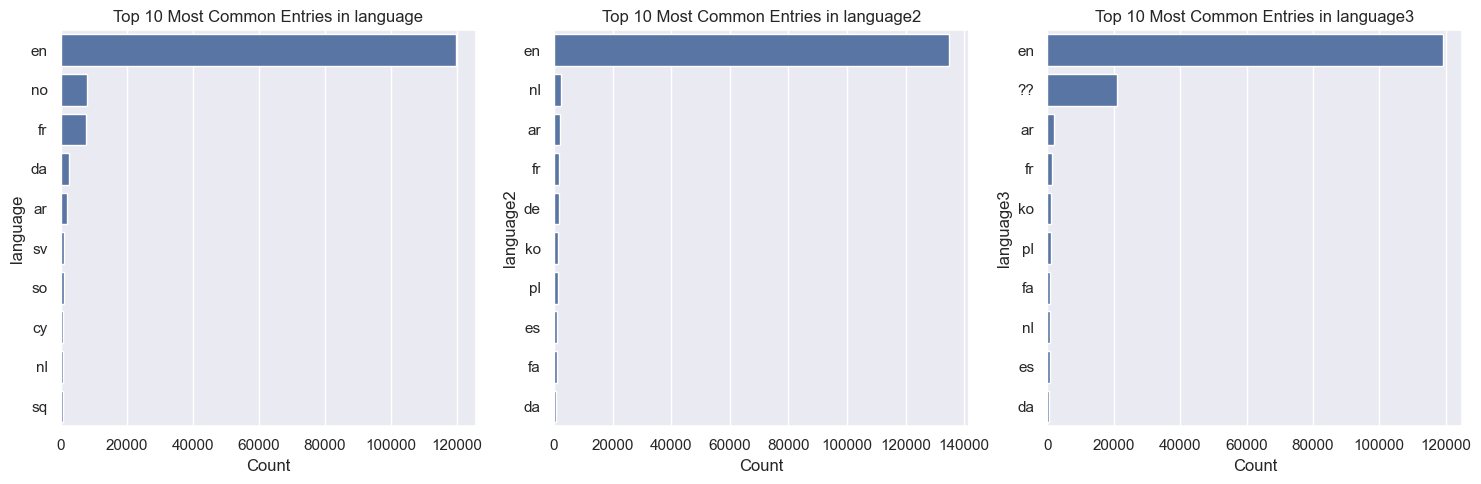

In [45]:
columns_to_plot = ['language', 'language2', 'language3']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(columns_to_plot):
    value_counts = df[column].value_counts(dropna=False).head(10)
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 Most Common Entries in {column}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()


In [46]:
# count the number of messages per language and their percentage, acumulated percentage and sorted by count
language_fld = 'language3'

language_counts = df[language_fld].value_counts()
language_counts = language_counts.reset_index()
language_counts.columns = [language_fld, 'count']
language_counts['percentage'] = language_counts['count'] / language_counts['count'].sum()
language_counts['cum_percentage'] = language_counts['percentage'].cumsum()
language_counts = language_counts.sort_values(by='count', ascending=False)

# print the language name from their code
language_counts['language_name'] = language_counts[language_fld].apply(lambda x: emoji.demojize(x))


# print the top 5 languages with the highest number of messages and their percentages and acumulated percentages formatted
total_langs = language_counts.shape[0]
print(f"Total number of languages: {total_langs}")
top_langs = 15
for index, row in language_counts.head(top_langs).iterrows():
    lang_code = row[language_fld]
    if lang_code == '??':
        language_name = 'Unknown'
    else:
        language_name = languages.get(alpha_2=lang_code).name
    print(f"{language_name:<9}({lang_code}): {row['count']: 7}({round(row['percentage'],4):6.2%}, {round(row['cum_percentage'],4):.2%})")


Total number of languages: 71
English  (en):  119054(79.10%, 79.10%)
Unknown  (??):   21107(14.02%, 93.12%)
Arabic   (ar):    2011( 1.34%, 94.45%)
French   (fr):    1518( 1.01%, 95.46%)
Korean   (ko):    1108( 0.74%, 96.20%)
Polish   (pl):     928( 0.62%, 96.82%)
Persian  (fa):     857( 0.57%, 97.39%)
Dutch    (nl):     724( 0.48%, 97.87%)
Spanish  (es):     661( 0.44%, 98.31%)
Danish   (da):     436( 0.29%, 98.59%)
Breton   (br):     209( 0.14%, 98.73%)
German   (de):     201( 0.13%, 98.87%)
Slovak   (sk):     197( 0.13%, 99.00%)
Indonesian(id):     148( 0.10%, 99.10%)
Vietnamese(vi):     136( 0.09%, 99.19%)


In [47]:
# Lenguajes por canal
# Cuantos lenguajes hay por canal
chat_lang = df.groupby('chat_id')[language_fld].nunique()
chat_lang = chat_lang.sort_values(ascending=False)
print(f"Number of languages by chat_id")
print(chat_lang)

# Cuantos lenguajes hay por usuario
user_lang = df.groupby('telegram_user_id')[language_fld].nunique()
user_lang = user_lang.sort_values(ascending=False)
print(f"Number of languages by user_id")
print(user_lang)

Number of languages by chat_id
chat_id
8.0       20
3508.0    18
1.0       17
81.0      16
208.0     15
          ..
2216.0     1
2247.0     1
2248.0     1
2257.0     1
3666.0     1
Name: language3, Length: 491, dtype: int64
Number of languages by user_id
telegram_user_id
848342.0     20
977908.0     16
848300.0     15
977890.0     15
2627215.0    15
             ..
2680663.0     1
2680695.0     1
2680720.0     1
289097.0      1
2699163.0     1
Name: language3, Length: 3892, dtype: int64


In [70]:
user_id = 848342.0
user_messages = df[(df['telegram_user_id'] == user_id) & (~df[language_fld].isin(['en', 'Unknown']))]
print(f"Number of messages from user {user_id}: {user_messages.shape[0]}")
print(f"Equivalent to % of Total : {user_messages.shape[0]/df.shape[0]:.2%}")

user_messages

Number of messages from user 848342.0: 818
Number of messages from user 848342.0: 0.54%


,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,date_source_posted_at,message_text_clean,message_encoding,...,message_words,message_lbr,message_encoding2,message_text_clean_utf8_2,language,language2,language2_score,language3,timestamp,year_month
4874,109626,FLM,2022-01-02 00:17:53+00,sell,8.0,848342.0,1 target done FLM Reached 0.3740 profit 21%🤑🚀🚀🤑🚀🔥🔥🎖🎖,2022-01-02 00:17:53+00:00,1 target done flm reached 0.3740 profit 21%,ascii,...,8,0,ascii,1 target done flm reached 0.3740 profit 21%,en,fr,0.453621,??,2022-01-02 00:17:53+00:00,2022-01
4875,114243,ZRX,2022-01-02 08:43:58+00,sell,8.0,848342.0,#ZRX/USDT\nFirst Target Achieved✅✅✅📈,2022-01-02 08:43:58+00:00,#zrx/usdt\nfirst target achieved,ascii,...,4,1,ascii,#zrx/usdt\nfirst target achieved,en,en,0.204383,??,2022-01-02 08:43:58+00:00,2022-01
4883,110158,ALGO,2022-01-05 07:46:33+00,buy,8.0,848342.0,📈 VIP SIGNAL: 0279\n\n💎$ALGO/USDT Long\n\n✅Risk Entry : 1.76 - Now at CMP\n✅Safe Entry : 1.72 - 1.69\nTP: \n☑️1) 1.80\n☑️2) 1.83\n☑️3) 1.86\n☑️4) 1.90\n☑️5) 1.94\n☑️6) 2.00\n \nLeverage: 10x - 50x\n\n🚫SL : 1.67\nDYOR\n#FUTURES,2022-01-05 07:46:33+00:00,vip signal: 0279\n$algo/usdt long\nrisk entry : 1.76 - now at cmp\nsafe entry : 1.72 - 1.69\ntp:\n1) 1.80\n2) 1.83\n3) 1.86\n4) 1.90\n5) 1.94\n6) 2.00\nleverage: 10x - 50x\nsl : 1.67\ndyor\n#futures,ascii,...,41,14,ascii,vip signal: 0279\n$algo/usdt long\nrisk entry : 1.76 - now at cmp\nsafe entry : 1.72 - 1.69\ntp:\n1) 1.80\n2) 1.83\n3) 1.86\n4) 1.90\n5) 1.94\n6) 2.00\nleverage: 10x - 50x\nsl : 1.67\ndyor\n#futures,en,no,0.564162,no,2022-01-05 07:46:33+00:00,2022-01
4887,110198,FTM,2022-01-06 14:14:51+00,sell,8.0,848342.0,#FTM/USDT\nFirst target achieved🚀🚀🔥📈\n165% profit🤩🤩,2022-01-06 14:14:51+00:00,#ftm/usdt\nfirst target achieved\n165% profit,ascii,...,6,2,ascii,#ftm/usdt\nfirst target achieved\n165% profit,en,en,0.169462,??,2022-01-06 14:14:51+00:00,2022-01
4892,113977,CLV,2022-01-07 20:29:09+00,buy,8.0,848342.0,"💎Long-Term Dip Buying Update💎\n\n\nCoins To Buy Now And HOLD Until The Next Bitcoin Halving.. Year 2024/2025\n\n\nDo Your Future Self A Huge Favor, BUY & Hold These Digital Gems Now....\n\n••••••••••••••••••••••••••••••\n\nBtc, Eth, Ftm, BNB, LTC, Luna, Algo, Ada, Shib, Doge, Vet, Sushi, Enj, Link, Keep, Dot, Ksm, LIT, Rune, Yfi, Band..\n\n\nDYDX, Zil, Etc, Omg, Mtl, C98, Twt, Coti, BLZ, Xtz, xlm, Xrp, cake, uni, NKN, MATIC, #Lit #Beam #Acala #Ksm #CLV #BNC #para, Trx, Etc, Theta, Waves, CHZ, Tfuel, Aave, Hbar, Sushi, ZRX..\n\n••••••••••••••••••••••••••••••\n\n*Metaverse & Gaming, Storage Coins To Hold *\n\n\nAxs, Mana, Enj, Sand, Ufo, Superfarm, YGG, iLV, RaCA, Starl, Atlas, Wild, TLM, SLP, ALICE, RNDR, Arweave, Luna, FTM, Rune, Solana, Atri, Polc, Derc, Saber, FTM, IoTX, Gala, PYR, Shill, Dar, Gmee, Rfox, Avax, Aioz, SiaCoin\n\n••••••••••••••••••••••••••••••\n\nYou Can Invest From $100 - $1000 & Above, On Each Of These Gems.\n\nAfter Investing, You Have To Be Very Patient For Pro...",2022-01-07 20:29:09+00:00,"long-term dip buying update\ncoins to buy now and hold until the next bitcoin halving.. year 2024/2025\ndo your future self a huge favor, buy & hold these digital gems now....\n••••••••••••••••••••••••••••••\nbtc, eth, ftm, bnb, ltc, luna, algo, ada, shib, doge, vet, sushi, enj, link, keep, dot, ksm, lit, rune, yfi, band..\ndydx, zil, etc, omg, mtl, c98, twt, coti, blz, xtz, xlm, xrp, cake, uni, nkn, matic, #lit #beam #acala #ksm #clv #bnc #para, trx, etc, theta, waves, chz, tfuel, aave, hbar, sushi, zrx..\n••••••••••••••••••••••••••••••\n*metaverse & gaming, storage coins to hold *\naxs, mana, enj, sand, ufo, superfarm, ygg, ilv, raca, starl, atlas, wild, tlm, slp, alice, rndr, arweave, luna, ftm, rune, solana, atri, polc, derc, saber, ftm, iotx, gala, pyr, shill, dar, gmee, rfox, avax, aioz, siacoin\n••••••••••••••••••••••••••••••\nyou can invest from $100 - $1000 & above, on each of these gems.\nafter investing, you have to be very patient for profit..\nthey will all pay off in ...",u

In [50]:
# filter the rows with language ar
filter_rows = df[language_fld] == 'fr'
print(f"Number of rows with language ar: {filter_rows.sum()}")
print("--------")
print("Columns with language ar")
df[filter_rows][['message_text_clean', 'message_text_clean_utf8', 'language3']]
for index, row in df[filter_rows][['message_text_clean', 'message_text_clean_utf8', 'language3']].head(3).iterrows():
    print(row['message_text_clean'])
    print("   -> ")
    print(row['message_text_clean_utf8'])
    print("--------")


Number of rows with language ar: 1518
--------
Columns with language ar
icp target 300u à
   -> 
icp target 300u à
--------
target 30u dc ko c lu
   -> 
target 30u dc ko c lu
--------
+10% là up trend
   -> 
+10% là up trend
--------


La identificación de lenguaje tiene falsos positivos, a pesar de eso es notorio y evidente que el lenguaje predominante es el ingles.

Creemos que el analisis del idioma va a ayudar en la búsqueda de relaciones entre grupos. Sin embargo, la identificación correcta del idioma requiere más trabajo respecto a:
- mensajes con más de un idioma
- mensajes cortos
- mensajes con pocas palabras en un idioma y codificaciones
- identificación de codificaciones que no tienen idiomas

#### 2.3.3. Mensajes duplicados

In [51]:
# Find duplicated messages 
duplicated_messages = df[df.duplicated(subset=['message_text_clean_utf8'], keep=False)]
duplicated_messages = duplicated_messages.sort_values(by=['message_text_clean_utf8'])
print(f"Number of duplicated messages: {duplicated_messages.shape[0]}")
# percentage of duplicated messages
print(f"Percentage of duplicated messages: {duplicated_messages.shape[0]/df.shape[0]:.2%}")
print("--------")


Number of duplicated messages: 52109
Percentage of duplicated messages: 34.62%
--------


In [52]:
duplicated_messages[['message_text_clean_utf8', 'chat_id', 'telegram_user_id']]

,message_text_clean_utf8,chat_id,telegram_user_id
56709,SCALPING 300 ]\n[star]s*cdega@ldegp*i... 1inc...,79.0,977825.0
56710,SCALPING 300 ]\n[star]s*cdega@ldegp*i... 1inc...,79.0,977825.0
56229,SCALPING 300 ]\n[star]s*cdega@ldegp*i... 1inc...,79.0,977825.0
56212,SCALPING 300 ]\n[star]s*cdega@ldegp*i... 1inc...,79.0,977825.0
55414,SCALPING 300 ]\n[star]s*cdega@ldegp*i... 1inc...,79.0,977825.0
...,...,...,...
149683,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0
149684,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0
149687,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0
149685,【get rich quickly】 chess and cards entertainm...,3578.0,3178785.0


In [53]:
duplicated_df = duplicated_messages.groupby('message_text_clean_utf8').agg({
    'id': lambda x: list(x),
    'telegram_user_id': lambda x: set(x),
    'chat_id': lambda x: set(x),
    'message_text_clean_utf8': 'size'
}).rename(columns={'message_text_clean_utf8': 'count'}).reset_index()

# Rename columns as required
duplicated_df = duplicated_df.rename(columns={'id': 'ids', 'telegram_user_id': 'users', 'chat_id': 'chats'})

duplicated_df['num_users'] = duplicated_df['users'].apply(len)
duplicated_df['num_chats'] = duplicated_df['chats'].apply(len)


# filter duplicated messages with more than one user or chat
filter_rows = (duplicated_df['num_users'] > 1) | (duplicated_df['num_chats'] > 1)
print(f"Number of duplicated messages with more than one user or chat: {filter_rows.sum()}")
# percentage of duplicated messages with more than one user or chat
print(f"Percentage of duplicated messages with more than one user or chat: {filter_rows.sum()/duplicated_df.shape[0]:.2%}")

print("--------")
print("Duplicated messages with more than one user or chat")
duplicated_df[filter_rows].sort_values(by='count', ascending=False) 


Number of duplicated messages with more than one user or chat: 6368
Percentage of duplicated messages with more than one user or chat: 38.69%
--------
Duplicated messages with more than one user or chat


,message_text_clean_utf8,ids,users,chats,count,num_users,num_chats
14476,ok,"[817634, 831305, 842364, 835834, 842267, 87413...","{2859521.0, 3000834.0, 2972162.0, 2976258.0, 2...","{2835.0, 2964.0, 3604.0, 3099.0, 3376.0, 3386....",234,202,24
5689,2 minutes left until our pump \nthe next messa...,"[166128, 214677, 64209, 218456, 207274, 222397...","{848448.0, 977862.0, 977904.0, 977907.0, 20313...","{136.0, 13.0, 142.0, 120.0, 2141.0}",207,5,5
6094,5 minutes left until our pump \nbe prepared fo...,"[64133, 65086, 64256, 168662, 5940, 29074, 167...","{977904.0, 848448.0, 977862.0, 977907.0}","{136.0, 120.0, 13.0, 142.0}",191,4,4
5452,10 minutes left until our pump,"[212291, 64121, 64512, 165664, 167169, 9934, 6...","{848448.0, 977958.0, 977904.0, 977907.0, 97797...","{136.0, 233.0, 108.0, 13.0, 120.0, 2141.0, 94.0}",174,7,7
5284,1 hour left until our pump,"[65200, 66159, 167144, 64459, 8754, 165490, 22...","{848448.0, 977958.0, 977904.0, 977907.0, 20313...","{136.0, 233.0, 13.0, 120.0, 2141.0, 94.0, 31.0}",161,7,7
...,...,...,...,...,...,...,...
9199,binance futures\n#skl/usdt take-profit target ...,"[200446, 200447]","{977827.0, 977901.0}","{210.0, 173.0}",2,2,2
9200,binance futures\n#skl/usdt take-profit target ...,"[212070, 212069]","{977827.0, 977846.0}","{210.0, 181.0}",2,2,2
9201,binance futures\n#skl/usdt take-profit target ...,"[200514, 200515]","{977827.0, 977901.0}","{210.0, 173.0}",2,2,2
9204,binance futures\n#skl/usdt take-profit target ...,"[201399, 201398]","{977827.0, 977901.0}","{210.0, 173.0}",2,2,2


Hemos comprobado que un 34.62% de los mensajes tienen duplicados, de estos mensajes el 38.69% son mensajes posteado por diferenctes usuarios o en diferentes canales y el resto por el mismo usuario y en el mismo canal.

En cuanto al contenido de los mensajes, hay mensajes muy genericos como 'ok' o '10 minutes left until our pump', y otros como 'binance futures\n#skl/usdt take-profit target ...' que indican monedas, exchange y acciones.

Considerando que este analisis simple, solo considerón mensajes identicos, cuando realicemos un analisis a nivel de patrones y contenido, seguro que las correlaciones y coincidencias serán mayores.

#### 2.3.4. Longitudes de texto
En esta revisión trabajaremos con las columnas de logitudes de texto adionadas:
- message_length
- message_lbr
- message_words

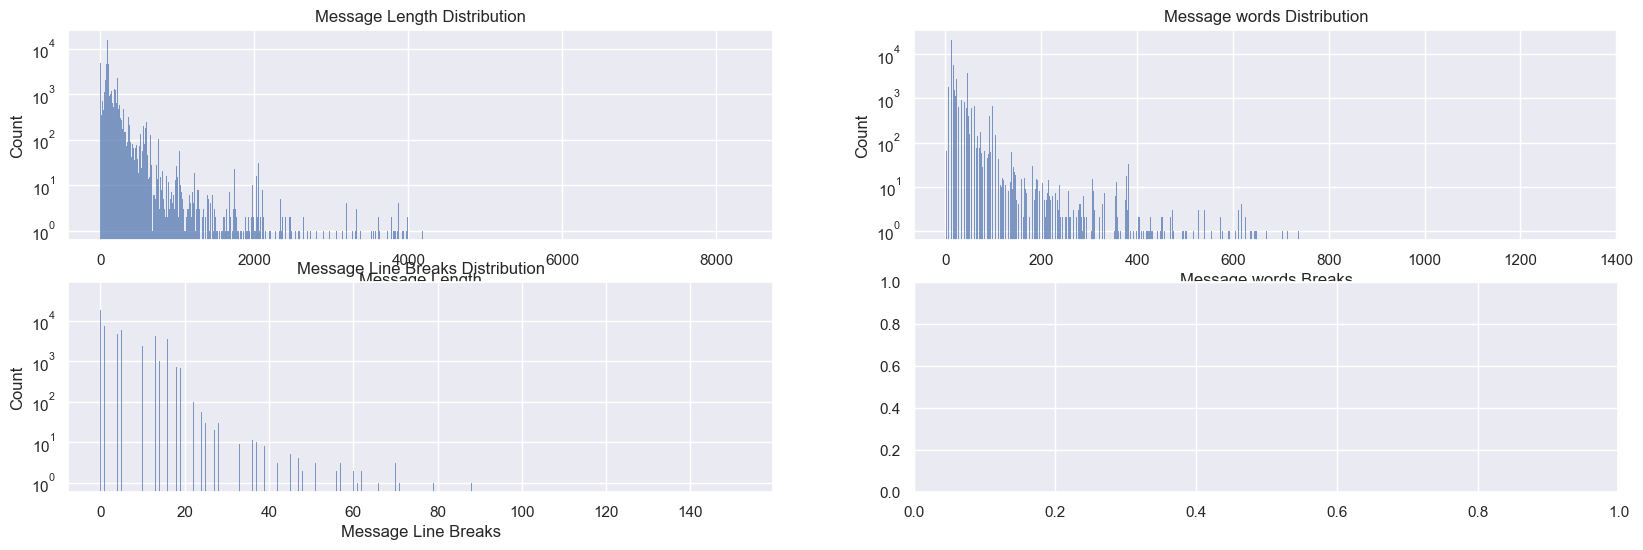

In [54]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(2, 2, figsize=(20, 6))
sns.histplot(data=df, x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

sns.histplot(data=df, x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

sns.histplot(data=df, x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

Como es esperable, hay una alta concentración de mensajes cortos, pocas palabras y saltos de linea.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado. Vemos que existen outliers en todas las distribuciones, los cuales podríamos analizar en más detalle.

In [55]:
df[['message_length', 'message_words', 'message_lbr']].describe()

,message_length,message_words,message_lbr
count,150519.000000,150519.000000,150519.000000
mean,156.400488,25.072336,4.724739
std,219.912153,37.131875,4.982413
min,1.000000,1.000000,0.000000
25%,80.000000,11.000000,2.000000
50%,96.000000,15.000000,3.000000
75%,172.000000,27.000000,5.000000
max,8322.000000,1338.000000,152.000000


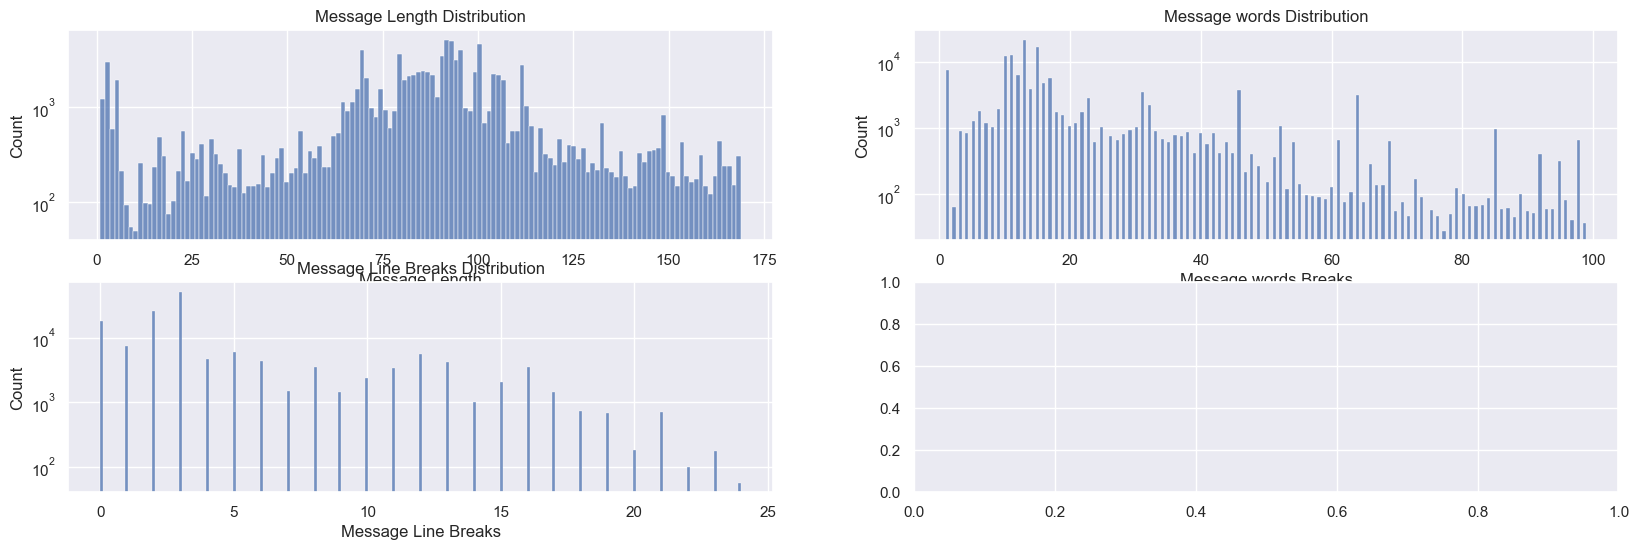

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

flt_ml = df['message_length'] < 170
sns.histplot(data=df[flt_ml], x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

flt_mw = df['message_words'] < 100
sns.histplot(data=df[flt_mw], x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

flt_mbr = df['message_lbr'] < 25
sns.histplot(data=df[flt_mbr], x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

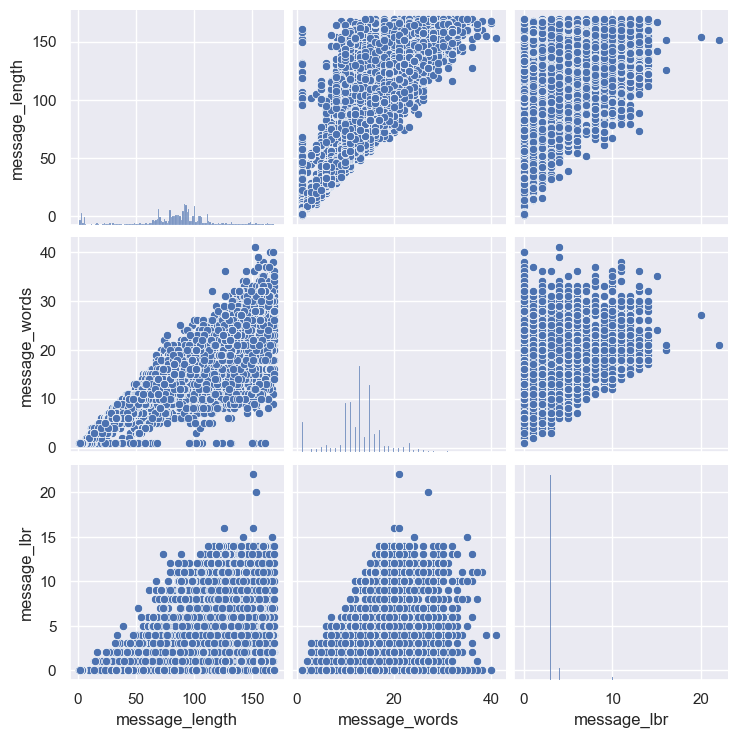

In [57]:
flt = flt_ml & flt_mw & flt_mbr
sns.pairplot(data=df[flt][['message_length', 'message_words', 'message_lbr']])
plt.show()

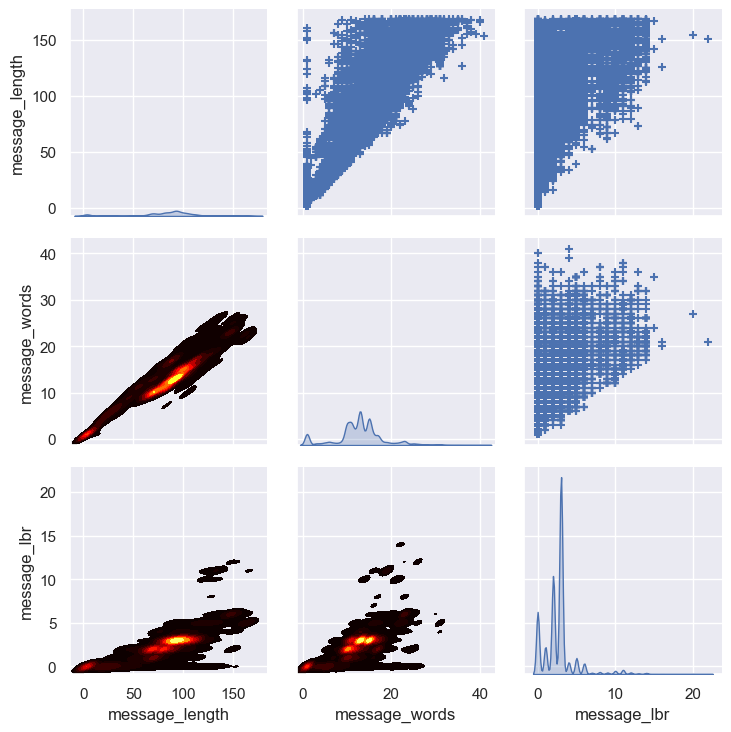

In [58]:
g = sns.PairGrid(df[flt][['message_length', 'message_words', 'message_lbr']])
g = g.map_upper(plt.scatter, marker='+')
g = g.map_lower(sns.kdeplot, cmap="hot",fill=True)
g = g.map_diag(sns.kdeplot, fill=True)


Al ver los plots cruzado con el mapa de calor, es claro que hay dos grupo de mensajes mayoritarios definidos por el numero de caracteres/palabras y los saltos de linea. Tambien se aprecia una relacion entre la longitud del mensaje y el numero de palabras, lo que es esperable.
Grupo 1 - mayor:
  - message_length: [50, 130]
  - message_lbr:    [2, 4]
  - message_words:  [9, 17]

Grupo 2 - menor:
  - message_length: [0, 15]
  - message_lbr:    [0, 2]
  - message_words:  [0, 5]


Estos grupos de mensajes puede que tengan mensajes similares en estrucutura. Es una pista para analizar con mayor profundidad.


### 2.4. Análisis cruzado de `commodity` y `trade_type`

El último análisis categórico que proponemos pretende cruzar las variables de `commodity` y `trade_type`, para ver qué tipo de operaciones son más comunes según la criptomoneda. Limitamos el análisis exploratorio a las 20 monedas con mayor cantidad de mensajes. Estas son: 

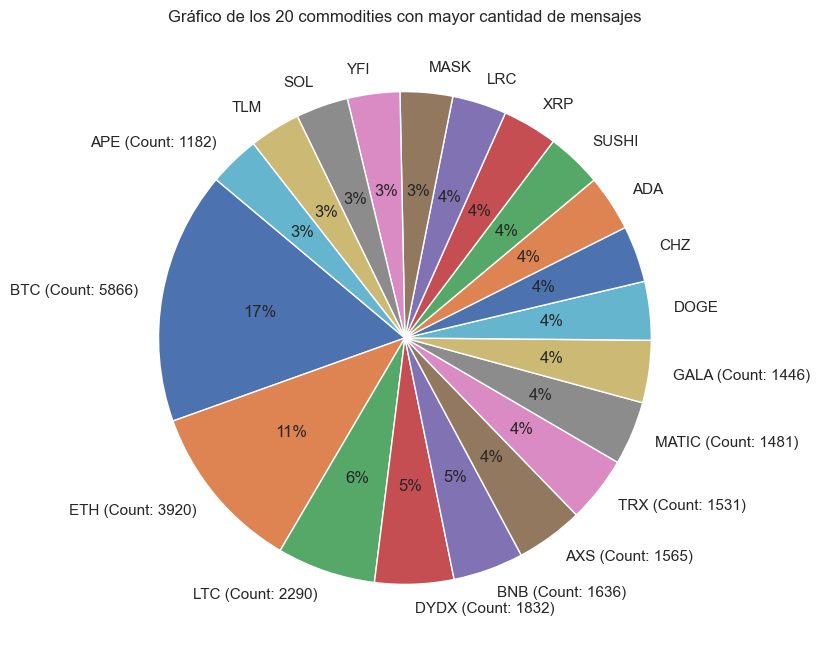

In [59]:
value_counts = df['commodity'].value_counts()
top_20_counts = value_counts.nlargest(20)

labels = []
for i, (index, value) in enumerate(zip(top_20_counts.index, top_20_counts)):
    if i < 9:
        labels.append(f'{index} (Count: {int(value)})')
    elif i==19:
        labels.append(f'{index} (Count: {int(value)})')
    else:
        labels.append(str(index))
        
# Create a pie chart
plt.figure(figsize=(8, 8))

plt.pie(top_20_counts, labels=labels, autopct='%1.0f%%', startangle=140)

# Title the plot
plt.title('Gráfico de los 20 commodities con mayor cantidad de mensajes')
top_20_entries = value_counts.nlargest(20).index
filtered_df = df[df['commodity'].isin(top_20_entries)]

Realizamos un gráfico de barras de estas 20 monedas, separando en tipo de operación:

<Axes: xlabel='Count', ylabel='commodity'>

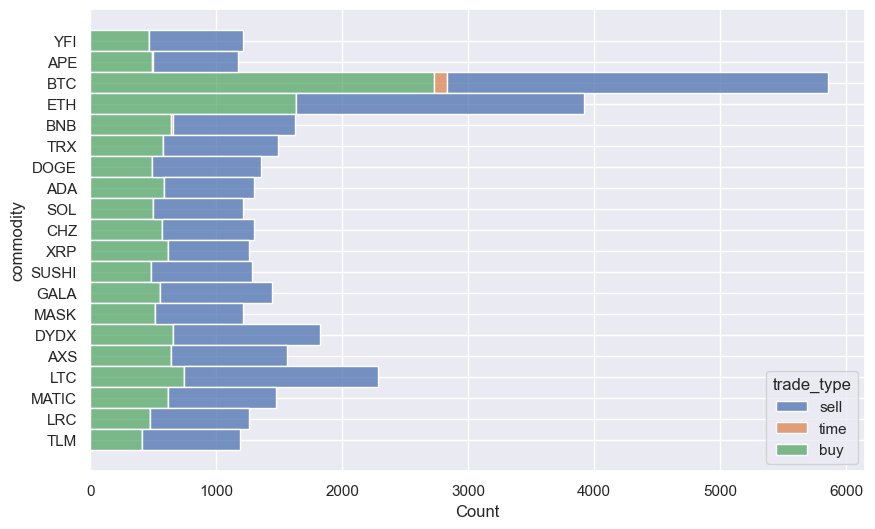

In [60]:
sns.histplot(data=filtered_df, y="commodity", hue="trade_type", multiple="stack")

Es curioso ver que en el top de commodities, la operación `time` aparece muy marcada en `BTC` y no en las otras.

In [61]:
pd.options.display.max_colwidth = 1000
filtered_df[(filtered_df['commodity']=='BTC')&(filtered_df['trade_type']=='time')]['message_text'].head(5)

737                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      6 hours left until the Mega Bull Call on Kucoin! \n\nWe have a lot of new members that have asked us if they should load USDT or BTC for this event. We will using the USDT pair, make sure you load USDT in your trading account in order to be ready for the Kucoin Mega Bull Call.\n\nRead pinned post. Stay

Como podemos ver de estos ejemplos, el campo `commodity` corresponde a `BTC`, pero en realidad no se está dando una orden de operación relativa a esta moneda, sino que simplemente aparece la mención de `BTC` en el cuerpo del mensaje. Es decir que esta columna debe ser tomada con cuidado, sin asumir que los valores reportados son 100% acertados.

## 3. Análisis en series de tiempo

Para poder describir el comportamiento de los grupos de Telegram y las relaciones que puedan existir entre ellos, es necesario analizar la cantidad y el tipo de mensajes enviados, en función del tiempo. La primer idea fue realizar una *dispersión* de los mensajes enviados por los 20 grupos con más mensajes.

/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/3708891129.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['source_posted_at'])


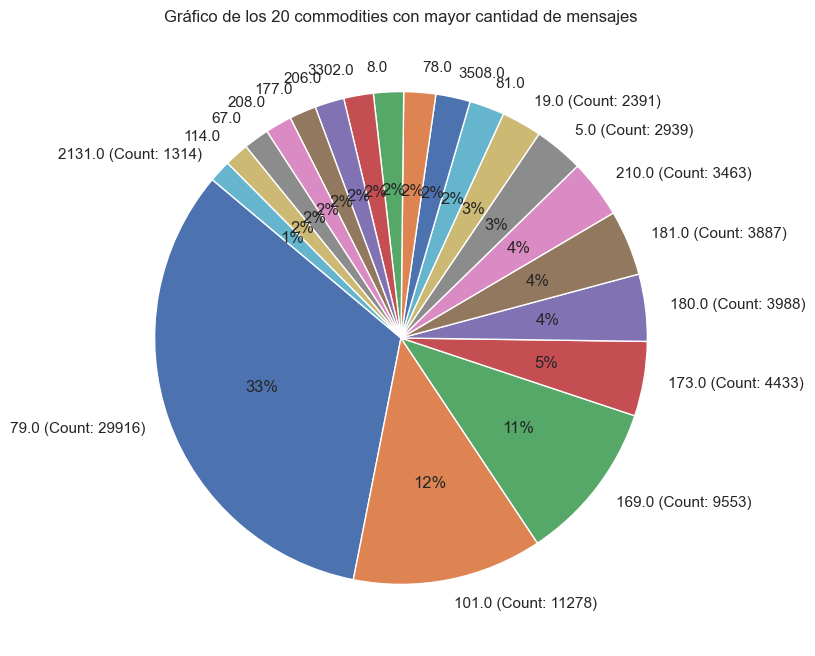

In [62]:
value_counts = df['chat_id'].value_counts()
top_20_counts = value_counts.nlargest(20)

labels = []
for i, (index, value) in enumerate(zip(top_20_counts.index, top_20_counts)):
    if i < 9:
        labels.append(f'{index} (Count: {int(value)})')
    elif i==19:
        labels.append(f'{index} (Count: {int(value)})')
    else:
        labels.append(str(index))
        
# Create a pie chart
plt.figure(figsize=(8, 8))

plt.pie(top_20_counts, labels=labels, autopct='%1.0f%%', startangle=140)

# Title the plot
plt.title('Gráfico de los 20 commodities con mayor cantidad de mensajes')

filtered_df['timestamp'] = pd.to_datetime(filtered_df['source_posted_at'])

top_20_entries = value_counts.nlargest(20).index
filtered_df = df[df['chat_id'].isin(top_20_entries)]



In [63]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['source_posted_at'])

oldest_entry = filtered_df['timestamp'].min()
newest_entry = filtered_df['timestamp'].max()

print(f'Mensaje más viejo: {oldest_entry}')
print(f'Mensaje más nuevo: {newest_entry}')

Mensaje más viejo: 2022-01-01 04:46:31+00:00
Mensaje más nuevo: 2022-12-30 23:59:45+00:00


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/3681641303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['source_posted_at'])


Text(0.5, 1.0, 'Dispersión de los 20 chats más populares a lo largo del tiempo')

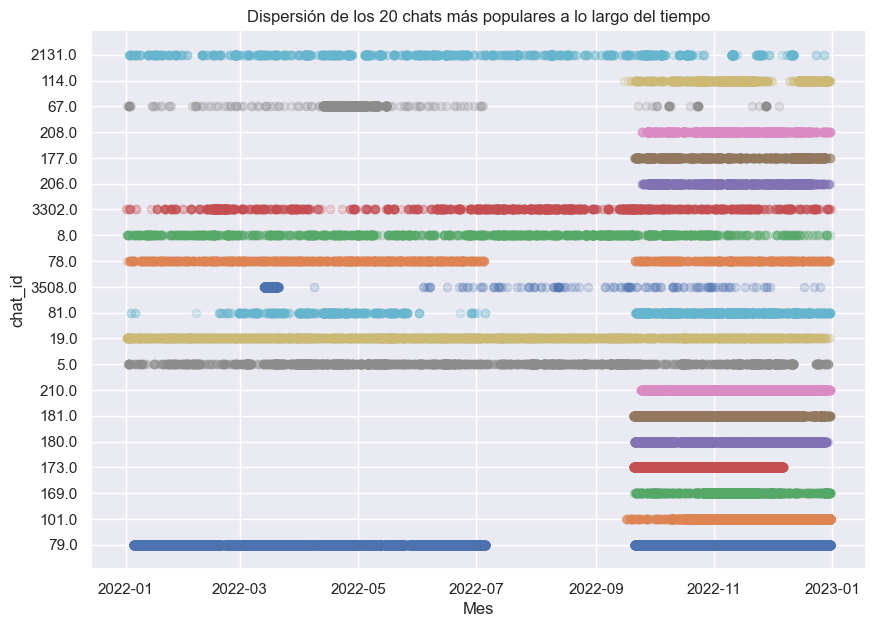

In [64]:
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot
i=1
for chat in top_20_entries:
    filter = (filtered_df['chat_id']==chat)
    ax.scatter(filtered_df[filter]['timestamp'], i*np.ones(len(filtered_df[filter]['timestamp'])), label=chat, alpha=0.2)
    i +=1
# Format the x-axis to display months in Spanish
#months_spanish = [calendar.month_name[i] for i in range(1, 13)]
#ax.xaxis.set_major_formatter(DateFormatter('%B'))  # '%B' for full month name
#ax.xaxis.set_major_locator(MonthLocator())
#plt.xticks(rotation=45)
plt.xlabel('Mes')  # 'Mes' means 'Month' in Spanish
plt.yticks(range(1,21), top_20_entries)
# Labeling and title
plt.ylabel('chat_id')  # 'Valor' means 'Value' in Spanish
plt.title('Dispersión de los 20 chats más populares a lo largo del tiempo')

Las conclusiones que podemos sacar son:
1. Muchos de los chats comenzaron su actividad en septiembre de 2022 (o al menos la toma de datos de muchos grupos comenzó en ese mes)
2. Existen períodos donde se envían muchos mensajes, y períodos donde no se envía ninguno
3. Es probable que haya períodos (semanas, meses) donde la mayoría de los mensajes provengan de un grupo que no está en este top20

Para observar el comportamiento global de los 20 grupos, realizamos una serie de tiempo de mensajes enviados por semana y por mes.

/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/3503263466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['source_posted_at'])
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/3503263466.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = filtered_df.resample('M').size()


Text(0.5, 1.0, 'Mensajes enviados por mes en los 20 chats más populares')

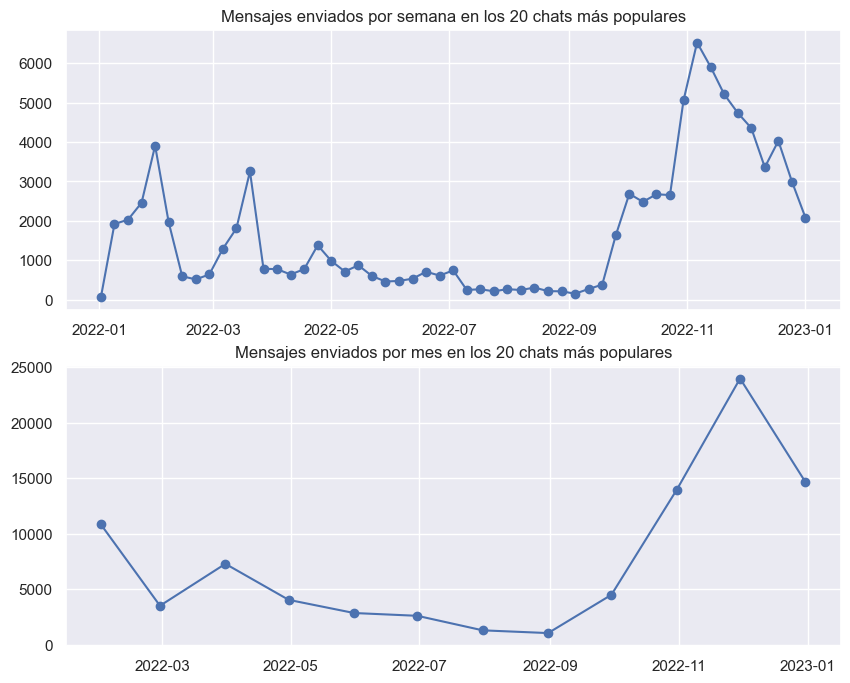

In [65]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['source_posted_at'])
filtered_df.set_index('timestamp', inplace=True)
fig, ax = plt.subplots(2,1, figsize=(10, 8))
daily_counts = filtered_df.resample('W').size() 
ax[0].plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')

ax[0].set_title('Mensajes enviados por semana en los 20 chats más populares')
monthly_counts = filtered_df.resample('M').size() 

ax[1].plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-')

ax[1].set_title('Mensajes enviados por mes en los 20 chats más populares')

Vemos que en los últimos meses de 2022 es cuando más mensajes se enviaron, por lo que tendría sentido analizar por separado períodos con muchos mensajes y períodos con pocos. Podemos también desglosar esta última gráfica mostrando por separado los 10 chats más populares.

/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/2417333503.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts = filtered_df[filter].resample('M').size()  # resample by day and count entries
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/2417333503.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts = filtered_df[filter].resample('M').size()  # resample by day and count entries
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/2417333503.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts = filtered_df[filter].resample('M').size()  # resample by day and count entries
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/2417333503.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' 

Text(0.5, 1.0, 'Mensajes enviados por mes en los 10 chats más populares')

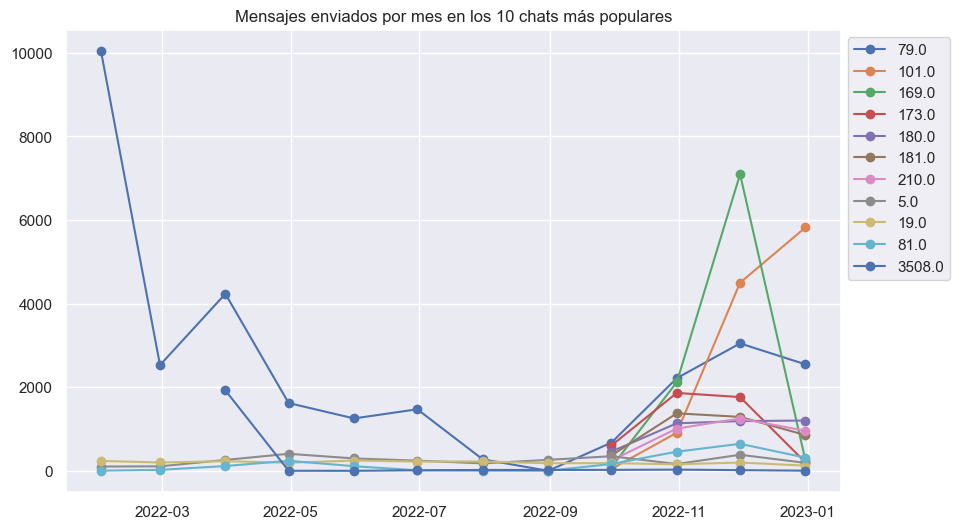

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
for chat in top_20_entries[0:11]:
    filter = (filtered_df['chat_id']==chat)
    daily_counts = filtered_df[filter].resample('M').size()  # resample by day and count entries
    ax.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', label=chat)
# Plotting the time series
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Mensajes enviados por mes en los 10 chats más populares')

Será necesario establecer un criterio para elegir qué grupos graficar, o buscar un nuevo tipo de gráfica, para conseguir visualizaciones claras que ilustren el comportamiento de los grupos de Telegram.

La siguiente idea fue buscar cuáles fueron los 3 meses con mayor cantidad de mensajes, y dentro de cada mes cuáles fueron los 5 grupos más activos. Esta información se imprime en pantalla y es presentada finalmente en una gráfica de mensajes por semana.

In [67]:
df['timestamp'] = pd.to_datetime(df['source_posted_at'])
df['year_month'] = df['timestamp'].dt.to_period('M')

# Count the number of occurrences for each year-month combination
month_counts = df['year_month'].value_counts()

# Identify the top three months with the most activity
top_3_months = month_counts.nlargest(3).index

print(top_3_months)

top_chat_ids_per_month = {}

# Loop through each of the top three months
for month in top_3_months:
    print(month)
    # Filter the DataFrame to include only rows from the current month
    filtered_df = df[df['year_month'] == month]
    # Count the occurrences of each 'chat_id' in the filtered DataFrame
    chat_id_counts = filtered_df['chat_id'].value_counts()
    # Identify the top five 'chat_id' groups
    top_5_chat_ids = chat_id_counts.nlargest(5)
    
    # Store the result in the dictionary
    top_chat_ids_per_month[month] = top_5_chat_ids

# Print the results
for month, top_5_chat_ids in top_chat_ids_per_month.items():
    print(f"Top 5 chat_id groups for {month}:")
    print(top_5_chat_ids)
    print()


PeriodIndex(['2022-11', '2022-10', '2022-12'], dtype='period[M]', name='year_month')
2022-11
2022-10
2022-12
Top 5 chat_id groups for 2022-11:
chat_id
169.0    7096
101.0    4500
79.0     3048
173.0    1764
181.0    1290
Name: count, dtype: int64

Top 5 chat_id groups for 2022-10:
chat_id
79.0     2216
169.0    2120
173.0    1863
181.0    1375
180.0    1136
Name: count, dtype: int64

Top 5 chat_id groups for 2022-12:
chat_id
101.0    5822
79.0     2547
180.0    1203
210.0     957
181.0     855
Name: count, dtype: int64



/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/3197338469.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['timestamp'].dt.to_period('M')


In [68]:
# Get the version of matplotlib
import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")


Matplotlib version: 3.9.0


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/414618636.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['timestamp'].dt.date
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/414618636.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = filtered_df['timestamp'].dt.date
/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_27899/414618636.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy o

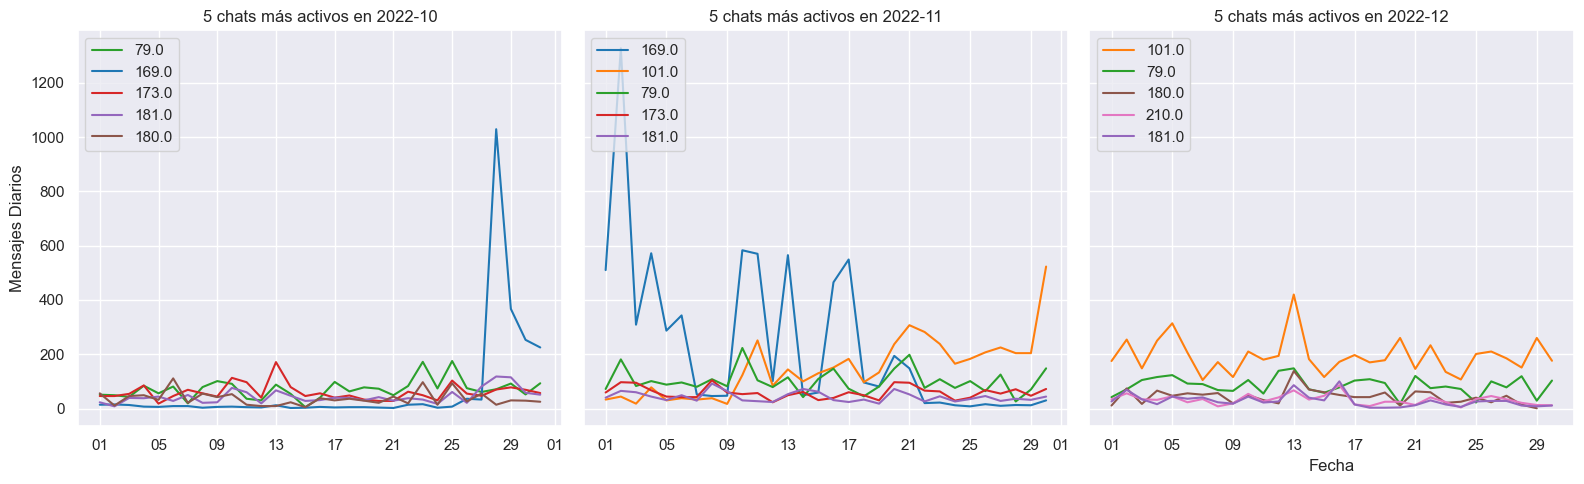

In [69]:
#Create a dictionary to store colors for each group
from matplotlib.dates import DateFormatter




color_map = {}
colors = matplotlib.colormaps.get_cmap('tab10').colors
# colors = matplotlib.colormaps.get_cmap('tab10', 7).colors

group_index = 0

for month, top_5_chat_ids in top_chat_ids_per_month.items():
    for group in top_5_chat_ids.index:
        if group not in color_map:
            color_map[group] = colors[group_index]
            group_index += 1


# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Plot the time series for each group in each subplot
top_3_months = np.sort(top_3_months)

for i, month in enumerate(top_3_months):
    ax = axs[i]
    filtered_df = df[df['year_month'] == month]
    filtered_df['date'] = filtered_df['timestamp'].dt.date
    
    for group in top_chat_ids_per_month[month].index:
        daily_counts = filtered_df[filtered_df['chat_id'] == group].groupby('date').size()
        ax.plot(daily_counts.index, daily_counts.values, label=group, color=color_map[group])
    ax.set_title(f'5 chats más activos en {month}')
    ax.xaxis.set_major_formatter(DateFormatter('%d'))
    
    ax.legend(loc='upper left')
    
    del filtered_df
# Set the x-axis label for the bottom subplot
axs[0].set_ylabel('Mensajes Diarios')
axs[-1].set_xlabel('Fecha')

# Show the plot
plt.tight_layout()
plt.show()

Las conclusiones que observamos de esto son:
1. Los meses más activos fueron oct, nov y dic del 2022 (meses consecutivos)
2. Entre mes y mes se repiten la mayoría de los grupos más activos, pero hay algunos que cambian (al menos dentro del top5, que fue elegido arbitrariamente)
3. Se comprueba lo observado en el gráfico de dispersión, existen períodos de poca actividad y períodos de mucha actividad
4. Algunos de estos períodos duran alrededor de 20 días, y no parecen coincidir con el inicio y fin de los meses
5. Parece existir una correlación entre algunos grupos, por ejemplo:
   * Los grupos con id 79.0 y 101.0 muestran los mismos picos de actividad entre el 09/11 y el 29/12
   * El grupo 180.0 tiene un comportamiento similar a los dos anteriores, pero no aparece en el top5 de noviembre
   * El grupo 169.0 muestra una gran cantidad de mensajes entre el 27/10 y el 07/11 que no se observa en los demás grupos. Sería interesante analizar ese grupo en particular y ver por qué motivos hay días en que se envían más de 500 mensajes (un número mucho mayor que el promedio)

In [72]:
df.info()
df.to_csv(work_file, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150519 entries, 0 to 150518
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   id                         150519 non-null  int64              
 1   commodity                  119324 non-null  object             
 2   source_posted_at           150519 non-null  object             
 3   trade_type                 141323 non-null  object             
 4   chat_id                    150262 non-null  float64            
 5   telegram_user_id           150262 non-null  float64            
 6   message_text               150519 non-null  object             
 7   date_source_posted_at      150519 non-null  datetime64[ns, UTC]
 8   message_text_clean         150519 non-null  object             
 9   message_encoding           150519 non-null  object             
 10  message_text_clean_utf8    150519 non-null  object      